# Purpose of Experiment and Introduction

This experiment is the implementation of Deepayan Das's "Adapting OCR with limited supervision" framework, as highlighted in the GitHub repository [Adapting-OCR](https://github.com/Deepayan137/Adapting-OCR), adapted to function with Francesco Pettini's License Plate Characters dataset, available on [Kaggle](https://www.kaggle.com/datasets/francescopettini/license-plate-characters-detection-ocr).

In this notebook I tried to adapt the model to the [LicensePlatesOverview ](https://www.kaggle.com/code/trainingdatapro/licenseplatesoverview) created by Training Data Pro. This dataset had a completely different philosophy compared to the previous ones, as it didn't offer the images of the license plates directly, instead offering broader pictures, out of which the license plates were annotated with bounding boxes. The crux of the challenge was to transform the images so that all my previous improvements would apply to this new dataset and its new challenges.

Unthankfully, as the dataset is even smaller in size compared to the previous ones, the model's performance is abyssimal. This is due to the fact that only a sample of the dataset is available for free on Kaggle, the rest being paywalled on the creator's website https://trainingdata.pro/data-market. This is stated explicitly in the dataset's description.


In [2]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

At first the complementing csv file (which is composed of the individual .csv files for each country) is filtered based on the criterion of "license_plate.visibility" in order to make sure that only valid license plate numbers are used in the model. Afterwards only the useful columns are kept such as the file name, the license number and the bounding boxes for license plates.

In [2]:
'''import pandas as pd

# Specify the path to the CSV file
file_path = 'Large_Dataset/combined_data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Filter the rows based on the value of the 'license_plate.visibility' column
filtered_df = df[df['license_plate.visibility'] == 'fully_visible']

# Select only the desired columns
final_df = filtered_df[['file_name', 'license_plate.mask', 'license_plate.number']]

# Now final_df contains the filtered data with only the desired columns'''


"import pandas as pd\n\n# Specify the path to the CSV file\nfile_path = 'Large_Dataset/combined_data.csv'\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv(file_path)\n\n# Filter the rows based on the value of the 'license_plate.visibility' column\nfiltered_df = df[df['license_plate.visibility'] == 'fully_visible']\n\n# Select only the desired columns\nfinal_df = filtered_df[['file_name', 'license_plate.mask', 'license_plate.number', 'license_plate.rows_count']]\n\n# Now final_df contains the filtered data with only the desired columns"

Following this, based on the bounding box coordinates and the filenames from the csv, the images are cropped and saved, thus containing only license plates.

In [4]:
import pandas as pd
from PIL import Image
import os

        
def crop_and_save_images(final_df):

    output_dir = './Large_Dataset/Cropped_Images'
    output_dir_label = './Large_Dataset/Cropped_Labels'
    os.makedirs(output_dir_label, exist_ok=True)



    for index, row in final_df.iterrows():
        img_path = f'Large_Dataset/Images/{row["file_name"]}'
        
        img = Image.open(img_path)

        # Parsing the 'license_plate.mask' column to get the bounding box coordinates
        mask_str = row['license_plate.mask'][1:-1]  # Remove the square brackets
        mask_coords = list(map(float, mask_str.split(',')))

        # Knowing the mask coordinates are in the format [x1, y1, x2, y2, x3, y3, x4, y4]
        xmin = min(mask_coords[::2])
        ymin = min(mask_coords[1::2])
        xmax = max(mask_coords[::2])
        ymax = max(mask_coords[1::2])

        # Converting the bounding box coordinates to integer pixel coordinates
        width, height = img.size
        xmin, ymin, xmax, ymax = map(int, (xmin * width, ymin * height, xmax * width, ymax * height))

        # Cropping the image
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        # Constructing the output file path
        base_name, ext = os.path.splitext(os.path.basename(img_path))
        output_file = f'{output_dir}/{base_name}_{index + 1}{ext}'

        # Saving the cropped image
        cropped_img.save(output_file)

        # Constructing the text file path
        text_file = f'{output_dir_label}/{base_name}_{index + 1}.txt'

        # Getting the license plate number
        license_plate_number = row['license_plate.number']

        # Saving the license plate number to the text file
        with open(text_file, 'w') as f:
            f.write(str(license_plate_number))



In [5]:
#crop_and_save_images(final_df)

Augmentation functions are defined so as to mitigate as much as possible the dataset's low size

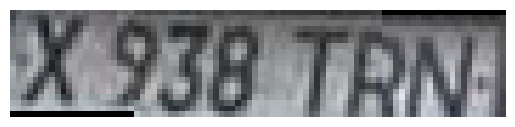

In [6]:
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import xml.etree.ElementTree as ET
import random

def augment_character(char_img):
    # Example augmentations using PIL
    char_img = char_img.rotate(random.uniform(-10, 10))  # Random rotation
    char_img = ImageEnhance.Color(char_img).enhance(random.uniform(0.8, 1.2))  # Random color adjustment
    char_img = ImageEnhance.Contrast(char_img).enhance(random.uniform(0.8, 1.2))  # Random contrast adjustment
    return char_img

def augment_image(img_path):
    img = Image.open(img_path)
    
    # Passing the original image to the augment_character function
    augmented_img = augment_character(img)

    return augmented_img

# Usage:
augmented_image = augment_image('./Large_Dataset/Cropped_Images/900900_285.jpg')


plt.imshow(augmented_image, cmap='gray')
plt.axis('off')
plt.show()

Data quality assurance purposes I began by creating a function which restores and displays the images loaded in the dataset by undoing the transformations done upon it (which are hardcoded but can be easilly changed selectively)

In [8]:
from matplotlib import pyplot as plt

# Helper function that I use to check if the images and labels are correctly loaded into the dataset class
def imshow(img, title=None):
    # Converting from Torch tensor to numpy array
    img = img.numpy().transpose((1, 2, 0))
    # Undoing normalization
    mean = 0.5
    std = 0.5
    img = std * img + mean
    img = img.clip(0, 1)  # Clip values to be between 0 and 1
    plt.imshow(img, cmap='gray' if len(img.shape)==2 else None)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausing to update the plots

The first major revision I have brought to the code was modifying the collator to simplify it and implement the resizing/padding of images based on the maximum size in the dataset (which became redundant as I implemented it directly in the SynthDataset class).

As I would later find out, some images in the dataset had large sizes, which meant that all the images loaded into the model had such large sizes. This led to significant problems with the GPU memory, as I was unable to properly run the model as it would simply run out of VRAM. 

At first I would try my best to improve the model's memory performance (consolidating variables into a single one, running memory profiling on various blocks of code, traces of which are still present in my code). After exhausting all possible solutions, thanks to the profiling, I have noticed that my dataset occupied a significant amount of memory, thus prompting me to discover my error.

I can thus say that I am keeping the image resizer here as a reminder of my error, even if I can safely remove it entirely.

In [3]:
class SynthCollator(object):
    def __call__(self, batch):
        imgs = [item['img'] for item in batch]
        augmented_imgs = [item['augmented_img'] for item in batch]
        
        imgs = torch.stack(imgs, 0)
        augmented_imgs = torch.stack(augmented_imgs, 0)
        
        indexes = [item['idx'] for item in batch]
        
        item = {'img': imgs, 'augmented_img': augmented_imgs, 'idx': indexes}
        
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        
        return item



Unlike the previous SynthDataset classes, this itteration doesn't need to read character data from `.xml` files and then concatenate it, instead it just reads the first line of associated `.txt` files for each image. This way it uses a more straighforward method of obtaining the label data.

The images are also resized to a height of just 64 pixels, as they have a lower image quality due to the nature of the raw images compared to the other datasets.

Besides this the class is mostly the same, just some file checking control lines were added to make sure there are no errors stemming from possible folders appearing in the search path.


In [4]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random
from PIL import Image, ImageEnhance
import xml.etree.ElementTree as ET

class SynthDataset(Dataset):
    def __init__(self, opt, train=True):
        super(SynthDataset, self).__init__()
        
        # Loading images
        self.img_dir = os.path.join(opt['path'], opt['imgdir'])
        
        # Loading annotations
        self.anno_dir = os.path.join(opt['path'], 'Cropped_Labels')
        
        # Ensuring only files are included, excluding directories
        self.images = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
        
        self.images = os.listdir(self.img_dir)
        
        # Train-Test splitting procedure
        
        random.seed(42)  # Setting seed for reproducibility
        random.shuffle(self.images)  # Shuffling the list of images
        self.train = train  # Flag to indicate if this is training or testing dataset
        
        # Splitting data into training and testing sets
        split_idx = int(0.8 * len(self.images))  # 80% for training
        train_images, test_images = self.images[:split_idx], self.images[split_idx:]
        
        # Using training data if train flag is True, else using testing data
        self.images = train_images if self.train else test_images
        self.nSamples = len(self.images)

        transform_list = [transforms.Resize((64, 128)),  # Resizing the pictures to a common dimension
                          transforms.Grayscale(1),
                          #transforms.RandomRotation(5),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def augment_character(self,char_img):
        # Example augmentations using PIL
        char_img = char_img.rotate(random.uniform(-10, 10))  # Random rotation
        char_img = ImageEnhance.Color(char_img).enhance(random.uniform(0.8, 1.2))  # Random color adjustment
        char_img = ImageEnhance.Contrast(char_img).enhance(random.uniform(0.8, 1.2))  # Random contrast adjustment
        return char_img

    def augment_image(self,img):

        # Passing the original image to the augment_character function
        augmented_img = augment_character(img)

        return augmented_img  
    
    def __getitem__(self, index):
        assert index < len(self), 'index range error'
        img_name = self.images[index]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Skip if img_path is a directory
        if os.path.isdir(img_path):
            return self.__getitem__(index + 1)
        
        anno_path = os.path.join(self.anno_dir, f"{img_name.split('.')[0]}.txt")

        img = Image.open(img_path)
        augmented_img = self.augment_image(img)  # Augmenting the image

        if self.transform is not None:
            img = self.transform(img)
            augmented_img = self.transform(augmented_img)  # Applying the transformations to augmented image

        with open(anno_path, 'r') as file:
            # Read the contents of the file
            label = file.read().strip()  # strip() removes any leading/trailing whitespace, including newlines

        item = {'img': img, 'augmented_img': augmented_img, 'idx': index, 'label': label}
        return item


The best model from the previous experiments was used in a modified version here. As the images have a different size, the model's architecture was change to accomodate this change, as the model would lead to a height of 1 too fast, a change in kernel size and stride size was needed, as well as a change in channels used.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out
    
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        
        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 2, 2, 2, 1]  # kernel size
        ps = [1, 1, 1, 1, 1, 1, 0, 0]  # padding size
        ss = [1, 1, 1, 1, 1, 1, 1, 2]  # stride size
        nm = [64, 128, 256, 256, 512, 512, 512, 512]  # channel number

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=True):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  
        convRelu(2, True)

        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        convRelu(3, True)
        cnn.add_module('resblock{0}'.format(3), ResidualBlock(256, 256))
        convRelu(4)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        convRelu(6, True)  # 512x1x16
        cnn.add_module('pooling{0}'.format(5), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        convRelu(7)



        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        
        conv = self.cnn(input.cuda(2))
        #print(f'conv size: {conv.size()}')
        drop = self.dropout(conv)
        b, c, h, w = conv.size()
        #print(h)
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output


In [11]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss


In [12]:
import torch.autograd.profiler as profiler


class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):


        input_, augmented_input, targets = batch['img'], batch['augmented_img'], batch['label']

        # Concatenating the original and augmented images along the batch dimension
        input_ = torch.cat((input_, augmented_input), dim=0)

        # Duplicating the targets for the augmented images
        targets, lengths = self.converter.encode(targets + targets)
        
        # Reduceding the number of variables for less strain on the memory
        logits = torch.nn.functional.log_softmax(self.forward(input_).contiguous().cpu(), 2)
        
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
            
        # Added this so that the variables will be freed from GPU memory after being used
        del input_, targets, lengths, logits, probs, preds, sim_preds
            

        return loss, ca, wa

    def run_epoch(self, validation=False):
        torch.cuda.empty_cache()

        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        with torch.no_grad():
            loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
            output = OrderedDict({
                'val_loss': abs(loss.item()),
                'val_ca': ca.item(),
                'val_wa': wa.item()
                })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result


I created this function so that the model would automatically find the least used GPU. For the purpose of handing out this assignment, this isn't exactly used anymore, as I have hardcoded the GPU device specifically to ensure maximum stability and reproduceability of the experiment.

In [13]:
import torch
import gpustat

# Function that identifies which is the least used gpu at the time (hardcoded in this build due to tensor inconsistency)
def get_least_used_gpu():
    stats = gpustat.GPUStatCollection.new_query()
    gpu_id = min(stats, key=lambda gpu: gpu.memory_used).index
    return gpu_id

print(get_least_used_gpu())
# Seting the least used GPU
torch.cuda.set_device(get_least_used_gpu())


2


In [14]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        '''if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)'''
        
        # Hardcoded to the 3rd GPU for stability purposes 
        device = torch.device("cuda:2")
        self.model = self.model.to(device)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=3, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)


Checking a sample of images from the training and testing set to make sure that the labels and the images are loaded properly.

<Figure size 640x480 with 0 Axes>

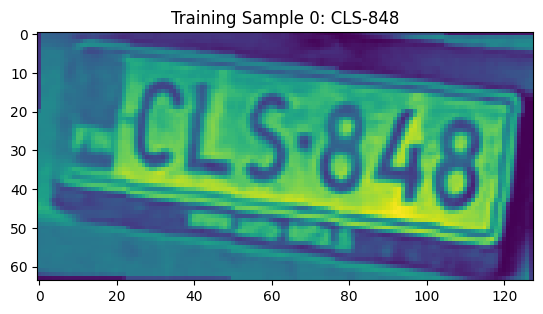

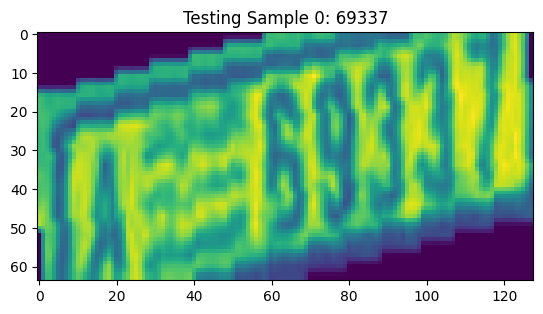

In [9]:
from matplotlib import pyplot as plt

opt = {'path': './Large_Dataset/', 'imgdir': 'Cropped_Images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

# Getting the first sample from the training and testing datasets
train_sample = train_dataset[8]
test_sample = test_dataset[8]

# Displaying the first training sample
plt.figure()
imshow(train_sample['augmented_img'], title=f"Training Sample 0: {train_sample['label']}")

# Displaying the first testing sample
plt.figure()
imshow(test_sample['augmented_img'], title=f"Testing Sample 0: {test_sample['label']}")


Checker function to see how the labels look like for debugging purposes, commented out due to its verbose output

In [16]:
'''import numpy as np

# Getting the total number of samples in the dataset
num_samples = len(train_dataset)

train_labels = []

# Iterating through the dataset 
for i in range(num_samples):
    sample = train_dataset[i]
    train_labels.append(sample['label'])

# Getting the unique labels and their counts
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))'''


"import numpy as np\n\n# Getting the total number of samples in the dataset\nnum_samples = len(train_dataset)\n\ntrain_labels = []\n\n# Iterating through the dataset \nfor i in range(num_samples):\n    sample = train_dataset[i]\n    train_labels.append(sample['label'])\n\n# Getting the unique labels and their counts\nunique, counts = np.unique(train_labels, return_counts=True)\nprint(dict(zip(unique, counts)))"


Changed the arguments to reflect the new dataset path, the new checkpoint save location, the learn rate and the number of epochs, the last two being for obtaining the best possible performance out of the model.

Besides this I have also changed the alphabet variable, as the prior one was too comprehensive and better suited for general words, while license plates are more standardized, using only upper-case letters and numbers. Dashes are present in the `alphabet` string for the padding purposes later on in the evaluation function.

In [17]:
# Newly defined alphabet, better suited for the task
alphabet = """QWERTYUIOPASDFGHJKLZXCVBNM1234567890-."""

args = {
    'name':'exp3',
    'path':'Large_Dataset',
    'imgdir': 'Cropped_Images',
    'imgH':64,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    # Experimented for a bit, the best results are with this lr and this amount of epochs
    'lr':0.0001,
    'epochs':100,
    'batch_size':32,
    'save_dir':'checkpoints_carplates_augmented_large',
    'log_dir':'logs_plates_augmented_large',
    'resume':False,
    'cuda':False,
    'schedule':False,
    
}

opt = {'path': './Large_Dataset/', 'imgdir': 'Cropped_Images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

args['collate_fn'] = SynthCollator()


args['data_train'], args['data_val'] = train_dataset, test_dataset
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train'])*2, len(args['data_val'])*2))
args['alphabet'] = alphabet
model = CRNN(args)


args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)


Epoch: [0]/[100] Training:   0%|          | 0/4 [00:00<?, ?it/s]

Traininig Data Size:228
Val Data Size:58
checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s, val_loss=7.51, val_ca=0, val_wa=0]


7.507472038269043
Validation loss decreased (inf --> 7.507472).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=7.36, val_ca=0, val_wa=0]


7.434959173202515
Validation loss decreased (7.507472 --> 7.434959).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=7, val_ca=0, val_wa=0]


7.291221936543782
Validation loss decreased (7.434959 --> 7.291222).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=6.14, val_ca=0, val_wa=0]


7.004162788391113
Validation loss decreased (7.291222 --> 7.004163).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=4.61, val_ca=0, val_wa=0]


6.524615859985351
Validation loss decreased (7.004163 --> 6.524616).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=3.53, val_ca=0, val_wa=0]


6.025399684906006
Validation loss decreased (6.524616 --> 6.025400).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.43, val_ca=0, val_wa=0]


5.65525576046535
Validation loss decreased (6.025400 --> 5.655256).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=3.45, val_ca=0, val_wa=0]


5.379568785429001
Validation loss decreased (5.655256 --> 5.379569).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s, val_loss=3.36, val_ca=0, val_wa=0]


5.1551087697347
Validation loss decreased (5.379569 --> 5.155109).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=3.35, val_ca=0, val_wa=0]


4.974301791191101
Validation loss decreased (5.155109 --> 4.974302).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3.33, val_ca=0, val_wa=0]


4.824833024631847
Validation loss decreased (4.974302 --> 4.824833).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s, val_loss=3.29, val_ca=0, val_wa=0]


4.696827590465546
Validation loss decreased (4.824833 --> 4.696828).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s, val_loss=3.28, val_ca=0, val_wa=0]


4.587719972317036
Validation loss decreased (4.696828 --> 4.587720).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s, val_loss=3.27, val_ca=0, val_wa=0]


4.493575828416007
Validation loss decreased (4.587720 --> 4.493576).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.28, val_ca=0, val_wa=0]


4.412354850769043
Validation loss decreased (4.493576 --> 4.412355).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s, val_loss=3.26, val_ca=0, val_wa=0]


4.340642556548119
Validation loss decreased (4.412355 --> 4.340643).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.26, val_ca=0, val_wa=0]


4.277341029223273
Validation loss decreased (4.340643 --> 4.277341).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=3.27, val_ca=0, val_wa=0]


4.221607300970289
Validation loss decreased (4.277341 --> 4.221607).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=3.31, val_ca=0, val_wa=0]


4.173690344157972
Validation loss decreased (4.221607 --> 4.173690).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s, val_loss=3.31, val_ca=0, val_wa=0]


4.130313813686371
Validation loss decreased (4.173690 --> 4.130314).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s, val_loss=3.29, val_ca=0, val_wa=0]


4.090228602999733
Validation loss decreased (4.130314 --> 4.090229).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s, val_loss=3.24, val_ca=0, val_wa=0]


4.051794377240268
Validation loss decreased (4.090229 --> 4.051794).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s, val_loss=3.24, val_ca=0, val_wa=0]


4.016534971154255
Validation loss decreased (4.051794 --> 4.016535).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=3.22, val_ca=0, val_wa=0]


3.983440190553665
Validation loss decreased (4.016535 --> 3.983440).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=3.33, val_ca=0, val_wa=0]


3.957387828826904
Validation loss decreased (3.983440 --> 3.957388).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=3.25, val_ca=0, val_wa=0]


3.9300403044773984
Validation loss decreased (3.957388 --> 3.930040).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=3.23, val_ca=0, val_wa=0]


3.904245694478353
Validation loss decreased (3.930040 --> 3.904246).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=3.27, val_ca=0, val_wa=0]


3.8816378712654114
Validation loss decreased (3.904246 --> 3.881638).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s, val_loss=3.24, val_ca=0, val_wa=0]


3.85958665814893
Validation loss decreased (3.881638 --> 3.859587).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=3.21, val_ca=0, val_wa=0]


3.8379220883051555
Validation loss decreased (3.859587 --> 3.837922).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.35, val_ca=0, val_wa=0]


3.8221516378464235
Validation loss decreased (3.837922 --> 3.822152).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=3.18, val_ca=0, val_wa=0]


3.8022153973579407
Validation loss decreased (3.822152 --> 3.802215).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.25, val_ca=0, val_wa=0]


3.7855839584812974
Validation loss decreased (3.802215 --> 3.785584).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s, val_loss=3.21, val_ca=0.431, val_wa=0]


3.7686803340911865
Validation loss decreased (3.785584 --> 3.768680).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=3.25, val_ca=0.431, val_wa=0]


3.7540011814662386
Validation loss decreased (3.768680 --> 3.754001).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=3.29, val_ca=0.431, val_wa=0]


3.7411539951960244
Validation loss decreased (3.754001 --> 3.741154).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s, val_loss=3.18, val_ca=0.431, val_wa=0]


3.7258651836498364
Validation loss decreased (3.741154 --> 3.725865).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s, val_loss=3.21, val_ca=0.431, val_wa=0]


3.7122246277959725
Validation loss decreased (3.725865 --> 3.712225).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s, val_loss=3.21, val_ca=0.862, val_wa=0]


3.6992331040211215
Validation loss decreased (3.712225 --> 3.699233).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=3.21, val_ca=0.862, val_wa=0]


3.6868802070617677
Validation loss decreased (3.699233 --> 3.686880).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=3.21, val_ca=0.862, val_wa=0]


3.6753625578996614
Validation loss decreased (3.686880 --> 3.675363).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s, val_loss=3.22, val_ca=0.862, val_wa=0]


3.664437708400545
Validation loss decreased (3.675363 --> 3.664438).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=3.22, val_ca=1.29, val_wa=0]


3.6540317812631296
Validation loss decreased (3.664438 --> 3.654032).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s, val_loss=3.26, val_ca=0.862, val_wa=0]


3.645114481449127
Validation loss decreased (3.654032 --> 3.645114).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=3.15, val_ca=1.29, val_wa=0]


3.634168010287815
Validation loss decreased (3.645114 --> 3.634168).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s, val_loss=3.19, val_ca=1.55, val_wa=0]


3.624527703160825
Validation loss decreased (3.634168 --> 3.624528).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s, val_loss=3.2, val_ca=0.862, val_wa=0]


3.615460142176202
Validation loss decreased (3.624528 --> 3.615460).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=3.18, val_ca=0.862, val_wa=0]


3.6064896285533905
Validation loss decreased (3.615460 --> 3.606490).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s, val_loss=3.26, val_ca=1.21, val_wa=0]


3.59935145961995
Validation loss decreased (3.606490 --> 3.599351).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=3.21, val_ca=1.64, val_wa=0]


3.5914769315719606
Validation loss decreased (3.599351 --> 3.591477).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s, val_loss=3.25, val_ca=1.21, val_wa=0]


3.584871343537873
Validation loss decreased (3.591477 --> 3.584871).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s, val_loss=3.27, val_ca=2.06, val_wa=0]


3.578901598086724
Validation loss decreased (3.584871 --> 3.578902).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s, val_loss=3.18, val_ca=0.862, val_wa=0]


3.5714630990658165
Validation loss decreased (3.578902 --> 3.571463).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=3.22, val_ca=1.64, val_wa=0]


3.564938050729257
Validation loss decreased (3.571463 --> 3.564938).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s, val_loss=3.28, val_ca=1.29, val_wa=0]


3.5596996307373048
Validation loss decreased (3.564938 --> 3.559700).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=3.27, val_ca=3.02, val_wa=0]


3.5545187847954884
Validation loss decreased (3.559700 --> 3.554519).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=3.23, val_ca=0.776, val_wa=0]


3.548819433178818
Validation loss decreased (3.554519 --> 3.548819).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s, val_loss=3.26, val_ca=2.98, val_wa=0]


3.5438265019449693
Validation loss decreased (3.548819 --> 3.543827).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s, val_loss=3.25, val_ca=2.37, val_wa=0]


3.5388724723104703
Validation loss decreased (3.543827 --> 3.538872).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s, val_loss=3.28, val_ca=3.9, val_wa=0]


3.5344889879226686
Validation loss decreased (3.538872 --> 3.534489).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s, val_loss=3.29, val_ca=2.2, val_wa=0]


3.530559250565826
Validation loss decreased (3.534489 --> 3.530559).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=3.27, val_ca=2.83, val_wa=0]


3.5262870250209684
Validation loss decreased (3.530559 --> 3.526287).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=3.17, val_ca=2.74, val_wa=0]


3.520668771531847
Validation loss decreased (3.526287 --> 3.520669).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s, val_loss=3.38, val_ca=3.32, val_wa=0]


3.5185466930270195
Validation loss decreased (3.520669 --> 3.518547).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s, val_loss=3.24, val_ca=1.68, val_wa=0]


3.514316019645104
Validation loss decreased (3.518547 --> 3.514316).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=3.3, val_ca=3.75, val_wa=0]


3.5111099300962505
Validation loss decreased (3.514316 --> 3.511110).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=3.32, val_ca=3.36, val_wa=0]


3.50825851355026
Validation loss decreased (3.511110 --> 3.508259).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=3.32, val_ca=5.17, val_wa=0]


3.505431427675135
Validation loss decreased (3.508259 --> 3.505431).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s, val_loss=3.36, val_ca=4.36, val_wa=0]


3.5033228362815967
Validation loss decreased (3.505431 --> 3.503323).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, val_loss=3.27, val_ca=4.66, val_wa=0]


3.500001379421779
Validation loss decreased (3.503323 --> 3.500001).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s, val_loss=3.25, val_ca=3.4, val_wa=0]


3.4964460352776756
Validation loss decreased (3.500001 --> 3.496446).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s, val_loss=3.29, val_ca=4.09, val_wa=0]


3.4935225480132632
Validation loss decreased (3.496446 --> 3.493523).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s, val_loss=3.37, val_ca=4.86, val_wa=0]


3.4918881475108945
Validation loss decreased (3.493523 --> 3.491888).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, val_loss=3.32, val_ca=4.17, val_wa=0]


3.489581916783307
Validation loss decreased (3.491888 --> 3.489582).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s, val_loss=3.27, val_ca=3.9, val_wa=0]


3.486677589416504
Validation loss decreased (3.489582 --> 3.486678).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, val_loss=3.37, val_ca=5.89, val_wa=0]


3.4851818743504976
Validation loss decreased (3.486678 --> 3.485182).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s, val_loss=3.39, val_ca=3.17, val_wa=0]


3.4838966920778347
Validation loss decreased (3.485182 --> 3.483897).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s, val_loss=3.27, val_ca=5.78, val_wa=0]


3.4810914198557534
Validation loss decreased (3.483897 --> 3.481091).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s, val_loss=3.33, val_ca=5.04, val_wa=0]


3.4791330747966525
Validation loss decreased (3.481091 --> 3.479133).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s, val_loss=3.3, val_ca=3.59, val_wa=0]


3.476845109462738
Validation loss decreased (3.479133 --> 3.476845).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s, val_loss=3.38, val_ca=5.92, val_wa=0]


3.4756971376913564
Validation loss decreased (3.476845 --> 3.475697).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, val_loss=3.39, val_ca=4.51, val_wa=0]


3.4746879164765523
Validation loss decreased (3.475697 --> 3.474688).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s, val_loss=3.42, val_ca=5.55, val_wa=0]


3.473994234958327
Validation loss decreased (3.474688 --> 3.473994).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=3.47, val_ca=5.79, val_wa=0]


3.4739103941690352
Validation loss decreased (3.473994 --> 3.473910).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s, val_loss=3.47, val_ca=4.44, val_wa=0]


3.4738146473379694
Validation loss decreased (3.473910 --> 3.473815).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s, val_loss=3.42, val_ca=2.83, val_wa=0]


3.47319074286971
Validation loss decreased (3.473815 --> 3.473191).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, val_loss=3.41, val_ca=4.24, val_wa=0]


3.4724358964240416
Validation loss decreased (3.473191 --> 3.472436).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=3.37, val_ca=4.93, val_wa=0]


3.4712550450455057
Validation loss decreased (3.472436 --> 3.471255).  Saving model ...


Epoch: [88]/[100] Training:  25%|██▌       | 1/4 [00:00<00:00,  7.14it/s, loss=1.37, train_ca=29.8, train_wa=0]

3.4713850878597645
EarlyStopping counter: (-3.471255 1 out of 3)


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s, val_loss=3.4, val_ca=7.43, val_wa=0]


3.470626632372538
Validation loss decreased (3.471255 --> 3.470627).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s, val_loss=3.44, val_ca=6.55, val_wa=0]


3.4703014368539327
Validation loss decreased (3.470627 --> 3.470301).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s, val_loss=3.36, val_ca=5.17, val_wa=0]


3.4691221895425217
Validation loss decreased (3.470301 --> 3.469122).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s, val_loss=3.37, val_ca=3.75, val_wa=0]


3.4680810025943223
Validation loss decreased (3.469122 --> 3.468081).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s, val_loss=3.46, val_ca=4.32, val_wa=0]


3.468027322850329
Validation loss decreased (3.468081 --> 3.468027).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s, val_loss=3.39, val_ca=6.53, val_wa=0]


3.4671807088349995
Validation loss decreased (3.468027 --> 3.467181).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s, val_loss=3.46, val_ca=6.9, val_wa=0]


3.46710908661286
Validation loss decreased (3.467181 --> 3.467109).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s, val_loss=3.34, val_ca=4.6, val_wa=0]


3.4657888166683235
Validation loss decreased (3.467109 --> 3.465789).  Saving model ...


Epoch: [97]/[100] Training:  25%|██▌       | 1/4 [00:00<00:00,  7.10it/s, loss=1.14, train_ca=41.4, train_wa=0]

3.4669730201059457
EarlyStopping counter: (-3.465789 1 out of 3)


Epoch: [98]/[100] Training:  25%|██▌       | 1/4 [00:00<00:00,  7.21it/s, loss=1.12, train_ca=30.4, train_wa=0]

3.46648767018559
EarlyStopping counter: (-3.465789 2 out of 3)


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s, val_loss=3.61, val_ca=6.43, val_wa=0]

3.467897038459778
EarlyStopping counter: (-3.465789 3 out of 3)
Early stopping


After running the model for 100 epochs with a learning rate of 0.0001, it became apparent that the model was simply not converging to an acceptable loss value. I suspect that this poor performance may be due to its limited data size, as the total dataset is composed of just 286 images.

In [18]:
!nvidia-smi

Thu Oct 12 20:36:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:03:00.0 Off |                  N/A |
| 88%   89C    P2             174W / 250W |  11128MiB / 11264MiB |     99%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
torch.cuda.empty_cache()

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
def get_accuracy(args, char_to_int):
    device = torch.device("cuda:2")
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model = model.to(device)  # Move the model to cuda:2
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, augmented_input, targets = batch['img'].to(device), batch['augmented_img'].to(device), batch['label']
        
        # Concatenate original and augmented images along the batch dimension
        input_combined = torch.cat((input_, augmented_input), dim=0)
        
        # Duplicate the targets for the augmented images
        targets_combined = targets + targets
        
        images.extend(input_combined.squeeze().detach())  # Now extending with combined images
        labels.extend(targets_combined)  # Now extending with combined targets
        
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        print(f'Batch {iteration + 1} Predictions: {sim_preds}')
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i]
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img.cpu() * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    
    true_labels = []
    pred_labels = []

    for true_label, pred_label in zip(labels, predictions):
        true_chars = [char for char in true_label if char in char_to_int]
        pred_chars = [char for char in pred_label if char in char_to_int]

        # Finding the maximum length between the two sequences
        max_length = max(len(true_chars), len(pred_chars))

        # Padding the shorter sequence with a dash ('.')
        true_chars_padded = true_chars + ['.'] * (max_length - len(true_chars))
        pred_chars_padded = pred_chars + ['.'] * (max_length - len(pred_chars))

        # Converting characters to integers and appending to lists
        true_labels.append([char_to_int[char] for char in true_chars_padded])
        pred_labels.append([char_to_int[char] for char in pred_chars_padded])

    # Flattening the lists for compatibility with sklearn metrics
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_pred_labels = [item for sublist in pred_labels for item in sublist]

    accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
    precision = precision_score(flat_true_labels, flat_pred_labels, average='weighted', zero_division = 0)
    recall = recall_score(flat_true_labels, flat_pred_labels, average='weighted', zero_division = 0)
    f1 = f1_score(flat_true_labels, flat_pred_labels, average='weighted')

    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    
    return ca, wa, accuracy, precision, recall, f1

Loading model checkpoints_carplates_augmented_large/exp3/best.ckpt


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Batch 1 Predictions: ['9TPN', '0N', '', 'LI8', '', 'A', '8N', 'N', '', 'N', '0', '', '0', '', 'BG14YN', '0', '0', '', 'E9', 'G0', '0', 'EIU-0', '', 'E-0', '7', '', 'AN', '', '']


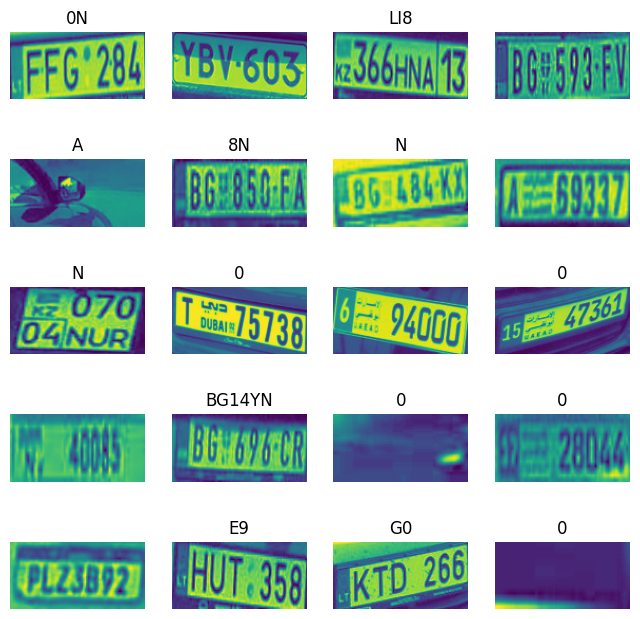

Character Accuracy: 4.60
Word Accuracy: nan
Accuracy: 0.02
Precision: 0.08
Recall: 0.02
F1 Score: 0.03


/home/guslasbo@GU.GU.SE/miniconda3/envs/Assignment1_ML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guslasbo@GU.GU.SE/miniconda3/envs/Assignment1_ML/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
char_to_int = {char: idx for idx, char in enumerate(alphabet)}

args['imgdir'] = 'test'
args['data'] = test_dataset
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')

if os.path.isfile(resume_file):
    print('Loading model %s' % resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    
    # Call the updated get_accuracy function
    ca, wa, accuracy, precision, recall, f1 = get_accuracy(args, char_to_int)
    
    # Print all the metrics
    print(f"Character Accuracy: {ca:.2f}")
    print(f"Word Accuracy: {wa:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')


Lastly, as we can see, the model's performance is also lacking. 

With a Character Accuracy of only 4.6, it means that only 4.6% characters are properly predicted by the model.

This trend of abyssimal scores continues with the sklearn Accuracy, Precision, Recall and F1 score, scoring below 0.1.

I suspect that the model's poor performance stems from the poor quality of the input images (them being mostly low quality crops). I believe this problem would be remedied by either using higher quality images or by using the entire paywalled dataset.
